In [1]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from IPython.display import Image


def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

# 1. Regularización

## Expansión de características polinomiales

In [2]:
from sklearn.linear_model import LogisticRegression
X,y = make_circles(200, noise=.05)

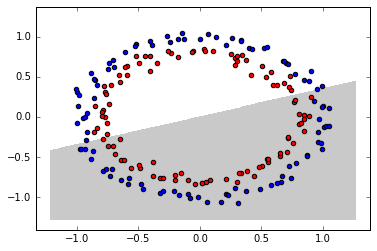

In [3]:
lr = LogisticRegression()
lr.fit(X,y)
plot_2Ddata_with_boundary(lr.predict, X,y)

In [4]:
X,y = make_circles(300, noise=.05)
X = np.vstack((X.T,X[:,0]**2+X[:,1]**2)).T
X.shape

(300, 3)

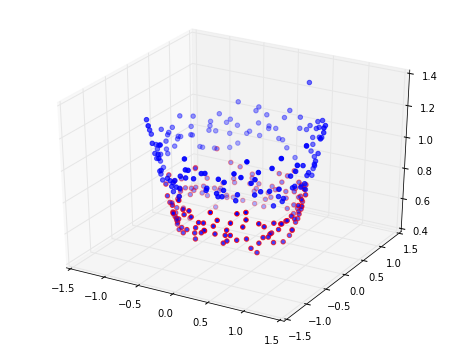

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0][y==0], X[:,1][y==0],X[:,2][y==0], color="blue")
ax.scatter(X[:,0][y==1], X[:,1][y==1],X[:,2][y==1], color="red")

In [6]:
lr = LogisticRegression()
lr.fit(X,y)
lr.score(X,y)

0.98666666666666669

## Regularización

Diseñamos la función de coste para que favorezca parámetros ($t$) con valores pequeños

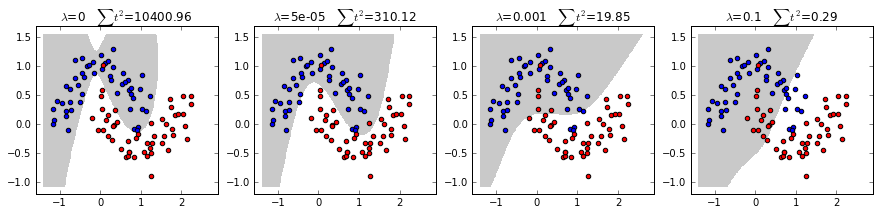

In [7]:
from IPython.display import Image
Image(filename='imgs/lrreg.png')

# 2. Evaluación del desempeño


0.8


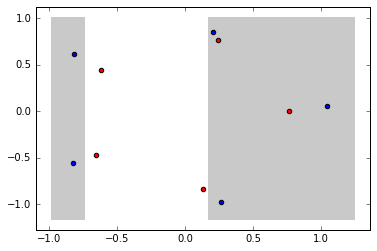

In [8]:
from sklearn.tree import DecisionTreeClassifier
X,y = make_circles(10, noise=.05)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X,y)
print dt.score(X,y)
plot_2Ddata_with_boundary(dt.predict, X,y)

In [9]:
y_predicts = dt.predict(X)

positives = y==1
negatives = y==0

print "accuracy", np.sum(y_predicts==y)*1./len(X)

print "TNR     ", np.sum(y_predicts[negatives]==0)*1./np.sum(negatives)
print "FPR     ", np.sum(y_predicts[negatives]==1)*1./np.sum(negatives)
print "TPR     ", np.sum(y_predicts[positives]==1)*1./np.sum(positives)
print "FNR     ", np.sum(y_predicts[positives]==0)*1./np.sum(positives)


accuracy 0.8
TNR      1.0
FPR      0.0
TPR      0.6
FNR      0.4


## Train/test split

In [10]:
from sklearn.cross_validation import train_test_split

Xtr,Xts, ytr,yts = train_test_split(X,y,test_size=.2)
print Xtr.shape, Xts.shape
print Xts.shape, yts.shape

(8, 2) (2, 2)
(2, 2) (2,)


/opt/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


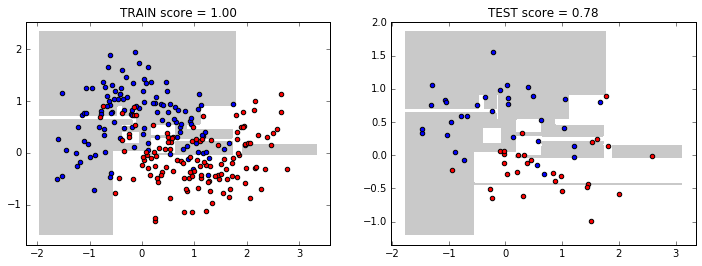

In [25]:
X,y = make_moons(300, noise=.4)
Xtr,Xts, ytr,yts = train_test_split(X,y,test_size=.2)
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(Xtr,ytr)
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_2Ddata_with_boundary(dt.predict, Xtr,ytr)
plt.title("TRAIN score = %.2f"%dt.score(Xtr,ytr))
plt.subplot(122)
plot_2Ddata_with_boundary(dt.predict, Xts,yts)
plt.title("TEST score = %.2f"%dt.score(Xts,yts))

## Cross validation
Fíjate cómo funciona la clase KFold en sklearn

In [12]:
from sklearn.cross_validation import KFold
X = np.random.randint(10, size=20)
for itr, its in KFold(len(X), n_folds=4):
    print itr, its

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3 4]
[ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19] [5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19] [10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15 16 17 18 19]


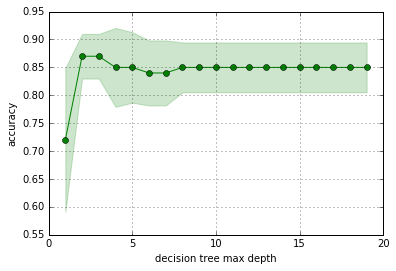

In [13]:
from sklearn.cross_validation import cross_val_score
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]
max_depths = range(1,20)

r = np.array([(np.mean(j), np.std(j)) for j in [cross_val_score(DecisionTreeClassifier(max_depth=i), 
                                                                X,y, 
                                                                cv=KFold(len(X), 5)) \
                                               for i in max_depths]])
plt.plot(max_depths, r[:,0], "o-", color="green", label="test")
plt.grid()
plt.fill_between(max_depths, r[:,0]-r[:,1], r[:,0]+r[:,1], color="green", alpha=.2)
plt.xlabel("decision tree max depth")
plt.ylabel("accuracy")

# 3. Statistical Learning Theory

En un escenario de clasificación tenemos un dataset de entrenamiento:
$S=\left\{ \left(x^{(i)},y^{(i)}\right);i=1..m\right\} $
 de tamaño
$m$
 donde los datos de entrenamiento
$\left(x^{(i)},y^{(i)}\right)$
 son muestreados iid de una distribución de probabilidad
$\mathcal{D}$.
 Tenemos una familia de hipótesis
$\mathcal{H}$
 que representa la clase de clasificadores que estamos considerando.
 Por ejemplo, la familia de todos los posibles clasificadores lineales
 podría definirse como
$\mathcal{H}=\left\{ h_{\theta}:h_{\theta}(x)=1\left\{ \theta^{T}x>0\right\} ,\theta\in\mathbb{R}^{n+1}\right\} $
 
$\begin{split}
\hat{\varepsilon}(h)=\frac{1}{m}\sum_{i=1}^{m}1\left\{ h(x^{(i)})\neq y^{(i)}\right\} &\;\;\;\; error\; de\; entrenamniento, error\; empírico,\; empirical\; risk \\
\varepsilon(h)=P_{(x,y)\sim\mathcal{D}}\left(h(x)\neq y\right) &\;\;\;\; error\; de\; generalización \\
\hat{h}=\underset{h\in\mathcal{H}}{{arg\, min}\ }\hat{\varepsilon}(h) &\;\;\;\; empirical\; risk\; minimization\;(ERM)\\
\varepsilon(\hat{h}) &\;\;\;\;error\;de\;generalización\;de\;la\;hipótesis\;obtenida\;mediante\;ERM\\
h^{*}=\underset{h\in\mathcal{H}}{{arg\, min}\ }\varepsilon(h)&\;\;\;\;la\;mejor\;hipótesis\;posible\;en\;\mathcal{H}\\
\varepsilon(h^{*})&\;\;\;\;error\;de\;generalización\;de\;la\;mejor\;hipótesis\;posible\;en\;\mathcal{H}
\end{split}$
 
Solo tenemos acceso a $S$, nuestro dataset de entrenamiento. No tenemos
acceso a $\mathcal{D}$ y por tanto no podemos conocer $h^{*}$. Es
este escenario, adoptamos la estrategia de _empirical risk minimization_,
tratando de encontrar $\hat{h}$, la hipótesis de $\mathcal{H}$ que
me minimiza el error de entrenamiento respecto a los datos que tengo
en $S$, esperando que $\varepsilon(\hat{h})$ se aproxime a $\varepsilon(h^{*})$.
Dentro de _Statistical Learning Theory_, tenemos un resultado
que nos garantiza esta convergencia cuando el número de datos, $m$,
aumenta. Este resultado establece que con probabilidad $1-\delta$:

$$\varepsilon(\hat{h})\leq\varepsilon(h^{*})+\mathcal{O}\left(\sqrt{\frac{d}{m}\log\frac{m}{d}+\frac{1}{m}\log\frac{1}{\delta}}\right)$$

donde $d=VC(\mathcal{H})$ es la dimensió>n Vapnik-Chervonenkis de
la familia de de hipótesis en cuestión. Esta dimensi<F3>n da una medida
de la complejidad de las hipótesis en $\mathcal{H}$ y, en la mayor<ED>a
de las ocasiones es aproximadamente linear en el número de par<E1>metros
de las hipótesis en$\mathcal{H}$.

## Bias/Variance

Dada una hipótesis concreta $h$, como por las que obtenemos después
de aplicar un m<E9>todo de optimización (gradiente descendiente, etc.)
en un escenario de regresión o clasificación. El error medio cuadrado
viene dado por

$$MSE=\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}-h_{\theta}(x^{(i)})\right)^{2}$$


Asumimos un escenario en el que los $y^{(i)}$ que medimos est<E1>n modelados
por una funci<F3>n determinista y desconocida por nosotros $f(x)$ y
que las mediciones est<E1>n afectadas por ruido, de forma que $y^{(i)}=f(x^{(i)})+\varepsilon$.
En promedio entre todos los elementos de $S$, el ruido es 0, es decir
$E\left[\varepsilon\right]=0$, pero cada elemento tiene su componente
de ruido$\neq0$. Idealmente, nos gustar<ED>a que descubrir un $h_{\theta}$tal
que $h_{\theta}=f$. Denotamos, por brevedad, $y^{(i)}$, $f(x^{(i)})$
e $h_{\theta}(x^{(i)})$ por $y_{i}$, $f_{i}$ y $h_{i}$ respectivamente.
El valor esperado del MSE es:

$$E\left[MSE\right]=\frac{1}{m}\sum_{i=1}^{m}E\left[\left(y_{i}-h_{i}\right)^{2}\right]
$$

La expresión $E\left[\left(y_{i}-h_{i}\right)^{2}\right]$ puede decomponerse
de la siguiente manera, ver [[Bias/Variance, Wikipedia](http://en.wikipedia.org/wiki/Bias-variance_dilemma)] para más detalles:
\begin{eqnarray*}
E\left[\left(y_{i}-h_{i}\right)^{2}\right] & = & E\left[\varepsilon^{2}\right]+E\left[\left(f_{i}-E\left[h_{i}\right]\right)^{2}\right]+E\left[\left(E\left[h_{i}\right]-h_{i}\right)^{2}\right]\\
 & = & Var(\varepsilon)+bias^{2}+Var\left(h_{i}\right)
\end{eqnarray*}


Es decir, el error de nuestra hipótesis $h$ tiene tres componentes:
un componente irreducible y asociado al ruido de medida, el sesgo
(_bias_ en inglés) debido a la desviación sistemática de $h$
respecto a $f$ y la varianza propia de $h$. La siguiente figura
ilustra los conceptos de sesgo y varianza [[ref](http://scott.fortmann-roe.com/docs/BiasVariance.html)]:




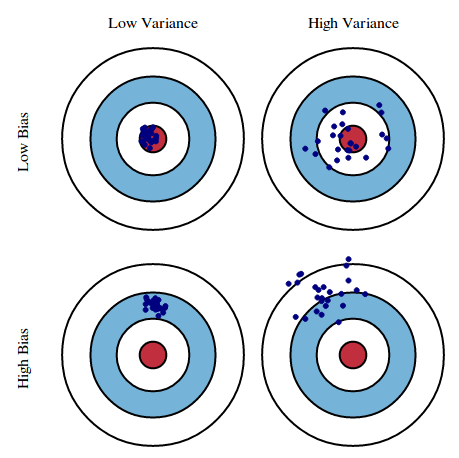

In [2]:
Image(filename='imgs/bv.png')

## Curvas de aprendizaje

Los siguientes ejemplos ilustran curvas de aprendizaje donde se muestra un caso con bias (izquierda), un caso con overfitting (centro), y un caso en el que inicialmente hay overfitting pero que solucionamos al añadir más datos (derecha).

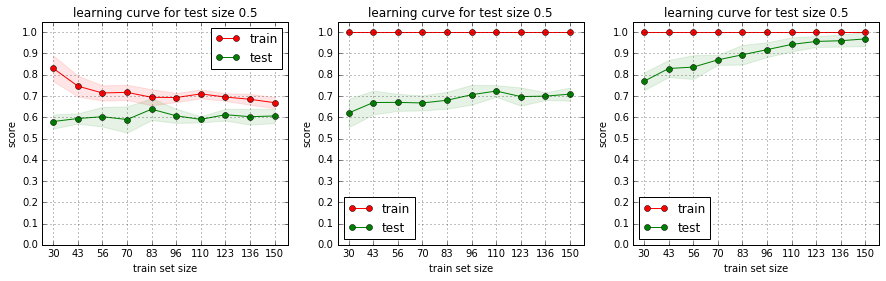

In [14]:
Image(filename='imgs/lc1.png')

En general, buscamos una familia de hipótesis $\mathcal{H}$ cuya
complejidad se ajuste a la naturaleza de la distribución $\mathcal{D}$
de la cual vienen nuestros datos. El problema es que no conocemos
nada de $\mathcal{D},$ solo tenemos $S$, una muestra. Si medimos
el sesgo y la varianza podemos tener alguna indicación sobre si ajuste
se esté dando con un $\mathcal{H}$ concreto. Según se ilustra en
la siguiente figura:

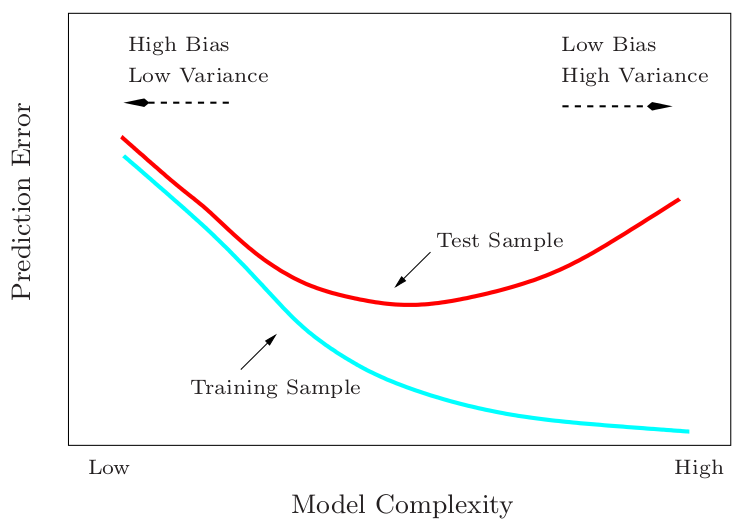

In [15]:
Image(filename='imgs/bvc.png')

Es decir, si medimos el comportamiento del error en nuestras muestras
de entrenamiento y de test podemos tener indicaciones sobre en qu<E9>
parte de la gráfica estamos, con un $h$ o $\mathcal{H}$ dados. En
general:

- Acciones que contribuyen a disminuir una varianza alta:

    - Aumentar el número de datos de entrenamiento (filas)
    - Disminuir el número de características (columnas)
    - Incrementar el parámetro de regularización (fuerza menor influencia de demasiados par<E1>metros)

- Acciones que contribuyen a disminuir el sesgo:

    - Aumentar el número de características (columnas)
    - Incluir características polinomiales, combinadas, etc.
    - Disminuir el parámetros de regularización.
